# Lab IS&A
## Bagattin Enrico - Alessandro Doretto

In [65]:
# Import
import pandas as pd
import numpy as np
import glob

# Modules
from utilities import *
from dataPreparation import *

In [ ]:
# Import data
years = [2017, 2018, 2019, 2020]
yearsForFeatures = [2016, 2017, 2018, 2019, 2020]
paths = []
for y in years:
    paths.append('matches/' + str(y) + '.xlsx') 
availablePaths = list(glob.glob("matches/20*.xlsx"))
matches = [pd.read_excel(path) for path in paths]
yearZeroForFeatures = pd.read_excel('matches/' + str(years[0]-1) + '.xlsx')
# TODO: Load matches based on number of past years choosen
df = pd.concat(matches, ignore_index=True, sort=False)
df.info()

In [ ]:
df.head().T

In [ ]:
df.describe(include='all', percentiles=[]).T

# Cleaning and preparing data

## Remove Winner/Loser reference
All the column with Winner/Loser reference will be substituted by Player0/Player1.

In [ ]:
df = removeWinnerLoserReference(df)
yearZeroForFeatures = removeWinnerLoserReference(yearZeroForFeatures)

## Filling null:
* Rank: take the max rank plus one
* Pts: set default zero	
* Avg odd: take mode of matches with same (or similar) players rank
* B365, PS: fill with avg

In [ ]:
rankDefault = max(df['Rank0'].max(), df['Rank1'].max())+1
df.fillna({'Rank0': rankDefault, 'Rank1': rankDefault, 'Pts0': 0, 'Pts1': 0}, inplace=True)

nullOddsDf = df[df[['B3650', 'B3651', 'PS0', 'PS1', 'Avg0', 'Avg1']].isna().any(axis=1)]
for index, row in nullOddsDf.iterrows():
    if pd.isnull(row['Avg0']) or pd.isnull(row['Avg1']):
        Avg0, Avg1 = findOddsForRow(row, df.dropna(subset=['Avg0', 'Avg1']))
        df.at[index, 'Avg0'] = row['Avg0'] = Avg0
        df.at[index, 'Avg1'] = row['Avg1'] = Avg1
    if pd.isnull(row['B3650']):
        df.at[index, 'B3650'] = row['Avg0']
    if pd.isnull(row['B3651']):
        df.at[index, 'B3651'] = row['Avg1']
    if pd.isnull(row['PS0']):
        df.at[index, 'PS0'] = row['Avg0']
    if pd.isnull(row['PS1']):
        df.at[index, 'PS1'] = row['Avg1']

df.dropna(subset=['Avg0', 'Avg1'], inplace=True) # Drop rows that hasn't similar rank matches
df.info()

## Handle Round ????????

In [ ]:
# X['Round'].value_counts()

In [ ]:
# you might change this according to a notion of weight
# X['Round'] = X['Round'].map ({  '1st Round'    : 1, 
#                                 '2nd Round'    : 2, 
#                                 '3rd Round'    : 4,
#                                 '4th Round'    : 8,
#                                 'Quarterfinals': 16,
#                                 'Round Robin'  : 32,
#                                 'Semifinals'   : 32,
#                                 'The Final'    : 64})

## New features
* [Elo rating](https://en.wikipedia.org/wiki/Elo_rating_system): a method for calculating the relative skill levels of players in zero-sum games
* Number of matches played during the last year
* Percentage of matches won during the last year
* Injuries: number matches in witch the player retired or walkover in the past year 
* Winning streak: current sequence of won games

In [ ]:
X = addEloRatingFeature(df)

In [ ]:
X = addMatchesPlayedAndWonFeatures(X, yearZeroForFeatures, yearsForFeatures)

In [ ]:
X = addInjuriesAndWinningStreakFeatures(X, yearZeroForFeatures, yearsForFeatures)

In [ ]:
X.to_csv('generated/beforeDuplication.csv', index=False)

## Row duplication
To use both match outcomes for our prediction models we will duplicate each row. We can do it by switching all the player features for each duplicated row and adding a Winner column for the match result

In [ ]:
X.columns

In [ ]:
duplication = X.copy()
duplication.columns = ['Date', 'Location', 'Tournament', 'Series', 'Court', 'Surface', 'Round',
       'Player1', 'Player0', 'Rank1', 'Rank0', 'Pts1', 'Pts0', 'Comment',
       'B3651', 'B3650', 'PS1', 'PS0', 'Avg1', 'Avg0', 'EloRating1',
       'EloRating0', 'MatchesPlayed1', 'MatchesPlayed0', 'MatchesWon1',
       'MatchesWon0', 'Injuries1', 'Injuries0', 'WinningStreak1',
       'WinningStreak0']

# Add the winner column
X = X.assign(Winner=np.zeros(X.shape[0])) # Player 0 always win
duplication = duplication.assign(Winner=np.ones(X.shape[0])) # Player 1 always win

X = pd.concat([X, duplication])
X.reset_index(inplace=True)
X.sort_values(by='index', inplace=True)
X.drop(columns=['Date', 'Comment', 'index'], inplace=True)

## One hot encoding
* Location
* Tournament
* Series
* Court
* Surface
* Round
* Players

In [ ]:
X = pd.get_dummies(X)
print('Total number of columns:', len(X.columns))

X.to_csv('generated/finalDataset.csv', index=False)


## Dataset subdivision: Train, Validation, Test

Train 60%, Validation 20%, Test 20% (taking as test the last part of the dataset)

In [ ]:
import pandas as pd

X = pd.read_csv('generated/finalDataset.csv')

X.head()

In [ ]:
from sklearn.model_selection import train_test_split

y = X.Winner.values
X.drop(columns='Winner', inplace=True)

test_size = len(X)//5
X_test     = X[-test_size:]
y_test     = y[-test_size:]
X_train_80 = X[:-test_size]
y_train_80 = y[:-test_size]

# Random split for training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train_80, y_train_80, test_size=0.25, random_state=42)

# Prediction models
We start by calculating how much powerful are the bookmakers' alghoritms, then we create and tune ours, let's see the results
## Baseline
Our first goal is to beat the average bookmaker accuracy

In [3]:
from sklearn.metrics import accuracy_score

#Player 1 wins if the odd is smaller than player 0
baseline = X_test['Avg1'] < X_test['Avg0']
baseline = baseline.astype(int)
baseline_test_acc = accuracy_score(y_true=y_test, y_pred=baseline)
print ("Test Accuracy: {:.2f}".format(baseline_test_acc*100), "%")

Test Accuracy: 68.46 %


In [4]:
accuraciesForModels = {'kNN': [], 'Naive Bayes': [], 'Decision Tree': [], 'Random Forest': []}

## k-Nearest-Neighbor Classifier

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
scaled_train = scaler.transform(X_train)
scaled_valid = scaler.transform(X_valid)
scaled_train_80 = scaler.transform(X_train_80)
scaled_test = scaler.transform(X_test)

In [ ]:
# Warning: kNN is very slow with this dataset

from sklearn import neighbors
from sklearn.metrics import accuracy_score

accuracies = []

for k in range(1,16):
    kNN = neighbors.KNeighborsClassifier(n_neighbors=k)
    kNN.fit(scaled_train, y_train)
    y_pred = kNN.predict(scaled_valid)
    valid_acc = accuracy_score(y_true=y_valid, y_pred=y_pred)
    print ("k: {:2d} | Validation Accuracy: {:.3f}".format(k, valid_acc))
    accuracies += [[valid_acc, k]]

In [5]:
# All the resulting accuracies for a faster running process purpose

accuracies =  [[0.5272562083585706, 1],
                [0.5399757722592369, 2],
                [0.5590551181102362, 3],
                [0.5632949727437916, 4],
                [0.5793458509993943, 5],
                [0.5838885523924894, 6],
                [0.5990308903694731, 7],
                [0.5896426408237432, 8],
                [0.6005451241671714, 9],
                [0.595396729254997, 10],
                [0.6053906723198061, 11],
                [0.5993337371290127, 12],
                [0.6035735917625682, 13],
                [0.5999394306480921, 14],
                [0.6078134463961236, 15]]

accuraciesForModels['kNN'] = accuracies

In [ ]:
best_accuracy, best_k = max(accuracies)
print ( "Best K", best_k )

# here we are using both training and validation,
# to exploit the most data

kNN = neighbors.KNeighborsClassifier(n_neighbors=best_k)
kNN.fit(scaled_train_80, y_train_80)

# Finally evaluate on test
test_acc = accuracy_score(y_true=y_test, y_pred=kNN.predict(scaled_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

## Naive Bayes

In [29]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# train and predict
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# compute Accuracy
train_acc = accuracy_score(y_true=y_train, y_pred=gnb.predict(X_train))
valid_acc = accuracy_score(y_true=y_valid, y_pred=gnb.predict(X_valid))
print ("Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(train_acc, valid_acc))

gnb.fit(X_train_80,y_train_80)

# Finally evaluate on test
test_acc = accuracy_score(y_true=y_test, y_pred=gnb.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

accuraciesForModels['Naive Bayes'] = [[valid_acc, 50]]

Train Accuracy: 0.852 - Validation Accuracy: 0.816
Test Accuracy: 0.815


## Decision Tree

In [7]:
from sklearn import tree
from sklearn.metrics import accuracy_score

accuracies = []

for max_leaves in range(5, 101, 5):
    # train and predict
    dt = tree.DecisionTreeClassifier(max_leaf_nodes=max_leaves)
    dt.fit(X_train, y_train)

    # compute Accuracy
    train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
    valid_acc = accuracy_score(y_true=y_valid, y_pred=dt.predict(X_valid))
    print ("Leaves: {:2d} - Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(
        max_leaves,  train_acc, valid_acc) )
    
    accuracies += [ [valid_acc, max_leaves] ]

best_accuracy, best_max_leaves = max(accuracies)
print ( "Best Max Leaves", best_max_leaves )

# here we are using both training and validation,
# to exploit the most data
dt = tree.DecisionTreeClassifier(max_leaf_nodes=best_max_leaves)
dt.fit(X_train_80,y_train_80)

# Finally evaluate on test
test_acc = accuracy_score(y_true=y_test, y_pred=dt.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

accuraciesForModels['Decision Tree'] = accuracies

Leaves:  5 - Train Accuracy: 0.852 - Validation Accuracy: 0.854
Leaves: 10 - Train Accuracy: 0.852 - Validation Accuracy: 0.854
Leaves: 15 - Train Accuracy: 0.854 - Validation Accuracy: 0.854
Leaves: 20 - Train Accuracy: 0.859 - Validation Accuracy: 0.848
Leaves: 25 - Train Accuracy: 0.861 - Validation Accuracy: 0.848
Leaves: 30 - Train Accuracy: 0.862 - Validation Accuracy: 0.846
Leaves: 35 - Train Accuracy: 0.864 - Validation Accuracy: 0.846
Leaves: 40 - Train Accuracy: 0.866 - Validation Accuracy: 0.845
Leaves: 45 - Train Accuracy: 0.867 - Validation Accuracy: 0.845
Leaves: 50 - Train Accuracy: 0.868 - Validation Accuracy: 0.845
Leaves: 55 - Train Accuracy: 0.872 - Validation Accuracy: 0.845
Leaves: 60 - Train Accuracy: 0.875 - Validation Accuracy: 0.844
Leaves: 65 - Train Accuracy: 0.876 - Validation Accuracy: 0.844
Leaves: 70 - Train Accuracy: 0.879 - Validation Accuracy: 0.844
Leaves: 75 - Train Accuracy: 0.880 - Validation Accuracy: 0.843
Leaves: 80 - Train Accuracy: 0.881 - Val

## Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn import tree
from sklearn.metrics import accuracy_score

accuracies = []

for estimators in range(1, 50, 4):
    # train a decision tree classifier
    rf = RandomForestClassifier(n_estimators=estimators)
    rf.fit(X_train, y_train)

    # compute Accuracy
    train_acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
    valid_acc = accuracy_score(y_true=y_valid, y_pred=rf.predict(X_valid))
    print ("Number of Trees: {:2d} - Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(
        estimators,  train_acc, valid_acc) )
    
    accuracies += [ [valid_acc, estimators] ]

best_accuracy, best_estimators = max(accuracies)
print ( "Best Number of Trees", best_estimators )

# here we are using both training and validation,
# to exploit the most data
rf = tree.DecisionTreeClassifier(max_leaf_nodes=best_estimators)
rf.fit(X_train_80,y_train_80)

# Finally evaluate on test
test_acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

accuraciesForModels['Random Forest'] = accuracies

Estimators:  1 - Train Accuracy: 0.897 - Validation Accuracy: 0.724
Estimators:  5 - Train Accuracy: 0.981 - Validation Accuracy: 0.816
Estimators:  9 - Train Accuracy: 0.993 - Validation Accuracy: 0.816
Estimators: 13 - Train Accuracy: 0.997 - Validation Accuracy: 0.838
Estimators: 17 - Train Accuracy: 0.997 - Validation Accuracy: 0.843
Estimators: 21 - Train Accuracy: 0.998 - Validation Accuracy: 0.842
Estimators: 25 - Train Accuracy: 0.999 - Validation Accuracy: 0.844
Estimators: 29 - Train Accuracy: 0.999 - Validation Accuracy: 0.846
Estimators: 33 - Train Accuracy: 0.999 - Validation Accuracy: 0.848
Estimators: 37 - Train Accuracy: 1.000 - Validation Accuracy: 0.847
Estimators: 41 - Train Accuracy: 1.000 - Validation Accuracy: 0.843
Estimators: 45 - Train Accuracy: 1.000 - Validation Accuracy: 0.842
Estimators: 49 - Train Accuracy: 1.000 - Validation Accuracy: 0.849
Best Estimators 49
Test Accuracy: 0.844


## Accuracy Results
Let's visualize all the results

In [55]:
cols = ['Model', 'Parameter', 'Accuracy']
accuraciesForPlots = pd.DataFrame(columns = cols)

for i, key in enumerate(accuraciesForModels):
    for el in accuraciesForModels[key]:
        accuraciesForPlots.loc[len(accuraciesForPlots)] = [key, el[1], el[0]]

accuraciesForPlots.head()

,Model,Parameter,Accuracy
0,kNN,1,0.527256
1,kNN,2,0.539976
2,kNN,3,0.559055
3,kNN,4,0.563295
4,kNN,5,0.579346


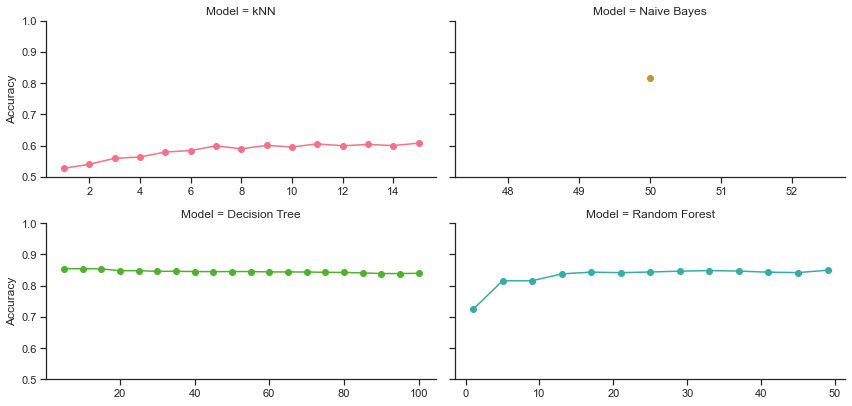

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")
sns.set_palette("husl")

grid = sns.FacetGrid(accuraciesForPlots, col="Model", aspect=2, ylim=(0.5, 1),
                     col_wrap=2, sharex=False, hue="Model")
grid.map(plt.axhline, y=0, ls=":", c=".5")
grid.map(plt.plot, 'Parameter', 'Accuracy', marker="o")
grid.set_axis_labels("", "Accuracy")

grid.savefig("generated/accuracies.png")

As we can see the kNN isn't very powerful with this type of predictions, the Naive Bayes model isn't bad but we can't tune it very much. So we will spend more effort with trying to increase the accuracy of the last two.

## Bias and Variance evaluation
We compute bias and variance by repeatedly training the models on different data samples.

### Decision Tree

In [15]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
import numpy as np

N_TESTS = 20

stats = pd.DataFrame(columns=['Trees', 'Type', 'Value'])
printProgressBar(0, 100, prefix='Progress:', suffix='Complete')

for max_leaves in range(5, 101, 5):
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        dt = DecisionTreeClassifier(max_leaf_nodes=max_leaves)
        dt.fit(Xs,ys)

        y_pred = dt.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2

    stats.loc[len(stats)] = [max_leaves, 'Error', dt_error.mean()]
    stats.loc[len(stats)] = [max_leaves, 'Bias', dt_bias.mean()]
    stats.loc[len(stats)] = [max_leaves, 'Variance', dt_variance.mean()]
    
    printProgressBar(max_leaves, 100, prefix='Progress:', suffix='Complete')


grid = sns.catplot(x='Trees', y='Value', hue='Type', kind='point', data=stats)
grid.set_axis_labels("Number of Leaves", "")

grid.savefig("generated/bias-variance-DT.png")

KeyboardInterrupt: 

As we can see from the results the variance seems to grow rapidly, so we can try to lower it using the bagging technique.

In [ ]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import numpy as np

N_TESTS = 20

stats = pd.DataFrame(columns=['Trees', 'Type', 'Value'])
printProgressBar(0, 35, prefix='Progress:', suffix='Complete')

for b_rounds in range(5, 36, 5):
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        dt = BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes=20), n_estimators=b_rounds)
        dt.fit(Xs,ys)

        y_pred = dt.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    dt_bias     = (y-np.mean(y_preds,axis=1))**2
    dt_variance = np.var(y_preds,axis=1)
    dt_error    = (y_preds - y.reshape(-1,1))**2

    stats.loc[len(stats)] = [b_rounds, 'Error', dt_error.mean()]
    stats.loc[len(stats)] = [b_rounds, 'Bias', dt_bias.mean()]
    stats.loc[len(stats)] = [b_rounds, 'Variance', dt_variance.mean()]
    
    printProgressBar(b_rounds, 35, prefix='Progress:', suffix='Complete')


grid = sns.catplot(x='Trees', y='Value', hue='Type', kind='point', data=stats)
grid.set_axis_labels("Bagging Rounds", "")

grid.savefig("generated/bias-variance-DT-bagging.png")

### Random Forest

In [ ]:
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
import numpy as np

N_TESTS = 20

stats = pd.DataFrame(columns=['Trees', 'Type', 'Value'])
printProgressBar(0, 50//4+1, prefix='Progress:', suffix='Complete')

for l in range(45, 100, 4):
    y_preds = np.array([])
    
    for i in range(N_TESTS):
        Xs, ys = resample(X,y, n_samples=int(0.67*len(y)) )

        rf = RandomForestClassifier(n_estimators=l)
        rf.fit(Xs,ys)

        y_pred = rf.predict(X)
        y_preds = np.column_stack( [y_preds, y_pred] ) if y_preds.size else y_pred

    rf_bias     = (y-np.mean(y_preds,axis=1))**2
    rf_variance = np.var(y_preds,axis=1)
    rf_error    = (y_preds - y.reshape(-1,1))**2

    stats.loc[len(stats)] = [l, 'Error', rf_error.mean()]
    stats.loc[len(stats)] = [l, 'Bias', rf_bias.mean()]
    stats.loc[len(stats)] = [l, 'Variance', rf_variance.mean()]
    
    printProgressBar(l//4+1, 50//4+1, prefix='Progress:', suffix='Complete')


grid = sns.catplot(x='Trees', y='Value', hue='Type', kind='point', data=stats)
grid.set_axis_labels("Number of Trees", "")

grid.savefig("generated/bias-variance-RF.png")

## Further improvements

We can see that Random Forest has a stable error over 30 (trees) and we can proceed with a more fine tuning. To improve Decision Tree we will try to apply the bagging technique to see the improvements.

### Bagging applied to Decision Tree

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

accuracies = []

for b_rounds in range(20, 51, 5):
    dt = BaggingClassifier(DecisionTreeClassifier(max_leaf_nodes=20), n_estimators=b_rounds)
    dt.fit(X_train, y_train)

    train_acc = accuracy_score(y_true=y_train, y_pred=dt.predict(X_train))
    valid_acc = accuracy_score(y_true=y_valid, y_pred=dt.predict(X_valid))
    print ("Bagging Rounds: {:2d} - Train Accuracy: {:.3f} - Validation Accuracy: {:.3f}".format(
        b_rounds,  train_acc, valid_acc) )
    
    accuracies += [ [valid_acc, b_rounds] ]

best_accuracy, best_b_rounds = max(accuracies)
print ( "Best Max Leaves", best_b_rounds )

dt = tree.DecisionTreeClassifier(max_leaf_nodes=best_b_rounds)
dt.fit(X_train_80,y_train_80)
test_acc = accuracy_score(y_true=y_test, y_pred=dt.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

Bagging Rounds: 20 - Train Accuracy: 0.859 - Validation Accuracy: 0.854
Bagging Rounds: 25 - Train Accuracy: 0.857 - Validation Accuracy: 0.855
Bagging Rounds: 30 - Train Accuracy: 0.859 - Validation Accuracy: 0.854
Bagging Rounds: 35 - Train Accuracy: 0.858 - Validation Accuracy: 0.853
Bagging Rounds: 40 - Train Accuracy: 0.858 - Validation Accuracy: 0.855
Bagging Rounds: 45 - Train Accuracy: 0.860 - Validation Accuracy: 0.853
Bagging Rounds: 50 - Train Accuracy: 0.858 - Validation Accuracy: 0.853
Best Max Leaves 40
Test Accuracy: 0.846


We have improved the validation accuracy, but the test one is worse

### Fine tuning Random Forest with Randomized Search

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [31]:
from sklearn.model_selection import RandomizedSearchCV

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 150, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [32]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(n_estimators=50)
# Random search of parameters 
# Default 5-fold cross validation, 50 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter = 100, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.2min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [33]:
rf_random.best_params_

{'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 52,
 'bootstrap': True}

Resulted in:

{'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 52,
 'bootstrap': True}

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=50, min_samples_split=10, min_samples_leaf=1, max_features='auto', max_depth=52)
rf.fit(X_train, y_train)

train_acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
print ("Train Accuracy: {:.3f}".format(train_acc))

valid_acc = accuracy_score(y_true=y_valid, y_pred=rf.predict(X_valid))
print ("Validation Accuracy: {:.3f}".format(valid_acc))

rf.fit(X_train_80,y_train_80)
test_acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
print ("Test Accuracy: {:.3f}".format(test_acc))

Train Accuracy: 0.976
Validation Accuracy: 0.852
Test Accuracy: 0.852


Our previous RF: Train Accuracy: 1.000 - Validation accuracy: 0.849 - Test accuracy: 0.844
  The tuned one: Train Accuracy: 0.976 - Validation Accuracy: 0.852 - Test Accuracy: 0.852
  
We've got a little gain!